# GI Tract Segmentation Competition

# Load And Prepare

## Imports

In [1]:
from fastai.vision.all import *
import matplotlib.patches as mpatches
import albumentations as A
import cv2
import pynvml
from scipy.spatial.distance import directed_hausdorff
import timm
import segmentation_models_pytorch as smp


# !cp kaggle.json /home/kgeorgio/.kaggle
# !kaggle competitions download -c uw-madison-gi-tract-image-segmentation


## Load CSV

In [2]:
train_df = pd.read_csv('dataset/train.csv', low_memory=False)
train_df = train_df.pivot(index='id', columns='class', values='segmentation').reset_index()

In [3]:
train_df.head()

class,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0001,NaN,NaN,NaN
1,case101_day20_slice_0002,NaN,NaN,NaN
2,case101_day20_slice_0003,NaN,NaN,NaN
3,case101_day20_slice_0004,NaN,NaN,NaN
4,case101_day20_slice_0005,NaN,NaN,NaN


In [4]:
path = Path('dataset/train')

fnames = get_image_files(path)

for ind, file_name in enumerate(fnames):
    print(file_name)
    if ind>9:
        print('...')
        break
print(f"And {len(fnames)-10} more lines.")

dataset/train/case101/case101_day26/scans/slice_0121_266_266_1.50_1.50.png
dataset/train/case101/case101_day26/scans/slice_0081_266_266_1.50_1.50.png
dataset/train/case101/case101_day26/scans/slice_0065_266_266_1.50_1.50.png
dataset/train/case101/case101_day26/scans/slice_0068_266_266_1.50_1.50.png
dataset/train/case101/case101_day26/scans/slice_0059_266_266_1.50_1.50.png
dataset/train/case101/case101_day26/scans/slice_0064_266_266_1.50_1.50.png
dataset/train/case101/case101_day26/scans/slice_0002_266_266_1.50_1.50.png
dataset/train/case101/case101_day26/scans/slice_0088_266_266_1.50_1.50.png
dataset/train/case101/case101_day26/scans/slice_0098_266_266_1.50_1.50.png
dataset/train/case101/case101_day26/scans/slice_0074_266_266_1.50_1.50.png
dataset/train/case101/case101_day26/scans/slice_0021_266_266_1.50_1.50.png
...
And 38486 more lines.


# Functions

In [5]:
def get_slice_id(fname):
    return fname.parts[3] + '_' + fname.parts[5][:10]


def rle_decode(mask_rle, shape, color=1):
    """ TBD

    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 

    Returns: 
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    # Split the string by space, then convert it into a integer array
    s = np.array(mask_rle.split(), dtype=int)

    # Every even value is the start, every odd value is the "run" length
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths

    # The image image is actually flattened since RLE is a 1D "run"
    if len(shape) == 3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)

    # The color here is actually just any integer you want!
    for lo, hi in zip(starts, ends):
        img[lo: hi] = color

    # Don't forget to change the image back to the original shape
    return img.reshape(shape)


def label_func(fname):
    # First we need to get the slice row
    slice_id = get_slice_id(fname)
    slice_row = train_df.query('id == @slice_id')

    # Then we need to extract the slice width and height which are provided in the fname last part
    # Typically the height is the first part of a dimension, but for some reason the slices have
    # widths provided first
    w, h = map(lambda x: int(x), fname.parts[-1].split('_')[2:4])

    # Create mask array (It needs to have 3 channels but fastai will only keep the first one anyways)
    mask = np.zeros((h, w, 3), dtype=np.uint8)

    # If the segmentation mask is str
    # Each mask should have it's own code (color) where fastai will use them for identification
    if isinstance(slice_row['large_bowel'].item(), str):
        mask[:, :, 0] = rle_decode(slice_row['large_bowel'].item(), shape=(h, w), color=255)

    if isinstance(slice_row['small_bowel'].item(), str):
        mask[:, :, 1] = rle_decode(slice_row['small_bowel'].item(), shape=(h, w), color=255)

    if isinstance(slice_row['stomach'].item(), str):
        mask[:, :, 2] = rle_decode(slice_row['stomach'].item(), shape=(h, w), color=255)

    return mask


# This was the code available in fastai
@ToTensor
def encodes(self, o: PILMask): return o._tensor_cls(image2tensor(o)[0])


# And this is how we customize it to suit our needs
@ToTensor
def encodes(self, o: PILMask): return o._tensor_cls(image2tensor(o))


@typedispatch
def show_batch(x: TensorImage, y: TensorMask, samples, ctxs=None, max_n=6, nrows=None, ncols=2,
               figsize=None, **kwargs):
    if figsize is None: figsize = (ncols * 3, max_n // ncols * 3)
    if ctxs is None: ctxs = get_grid(max_n, nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ctx in enumerate(ctxs):
        x_i = x[i] / x[i].max()
        show_image(x_i, ctx=ctx, cmap='gray', **kwargs)
        show_image(y[i], ctx=ctx, cmap='Spectral_r', alpha=0.35, **kwargs)
        red_patch = mpatches.Patch(color='red', label='large_bowel')
        green_patch = mpatches.Patch(color='green', label='small_bowel')
        blue_patch = mpatches.Patch(color='blue', label='stomach')
        ctx.legend(handles=[red_patch, green_patch, blue_patch], fontsize=figsize[0] / 2)


def pad_img(img, up_size=None):
    if up_size is None:
        return img
    shape0 = np.array(img.shape[:2])
    resize = np.array(up_size)
    if np.any(shape0 != resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0 // 2, pad0 // 2 + pad0 % 2]
        padx = [pad1 // 2, pad1 // 2 + pad1 % 2]
        img = np.pad(img, [pady, padx])
        img = img.reshape((*resize))
    return img


def unpad_img(img, up_size, org_size):
    shape0 = np.array(org_size)
    resize = np.array(up_size)
    if np.any(shape0 != resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0 // 2, pad0 // 2 + pad0 % 2]
        padx = [pad1 // 2, pad1 // 2 + pad1 % 2]
        img = img[pady[0]:-pady[1], padx[0]:-padx[1], :]
        img = img.reshape((*shape0, 3))
    return img


def load_image(fname, up_size=None):
    img = np.array(Image.open(fname))
    img = np.interp(img, [np.min(img), np.max(img)], [0, 255])
    return pad_img(img, up_size)


def get_25D_image(row, up_size=None):
    if up_size:
        imgs = np.zeros((*up_size, len(row['fnames'])))
    else:
        imgs = np.zeros((row['slice_h'], row['slice_w'], len(row['fnames'])))

    for i, fname in enumerate(row['fnames']):
        img = load_image(fname, up_size)
        imgs[..., i] += img
    return imgs.astype(np.uint8)


def get_mask(row, up_size=None):
    if up_size:
        mask = np.zeros((*up_size, 3))
    else:
        mask = np.zeros((row['slice_h'], row['slice_w'], 3))

    if isinstance(row['large_bowel'], str):
        mask[..., 0] += pad_img(
            rle_decode(row['large_bowel'], shape=(row['slice_h'], row['slice_w']), color=255), up_size)
    if isinstance(row['small_bowel'], str):
        mask[..., 1] += pad_img(
            rle_decode(row['small_bowel'], shape=(row['slice_h'], row['slice_w']), color=255), up_size)
    if isinstance(row['stomach'], str):
        mask[..., 2] += pad_img(
            rle_decode(row['stomach'], shape=(row['slice_h'], row['slice_w']), color=255), up_size)

    return mask.astype(np.uint8)


def get_train_aug(img_size, crop=0.9, p=0.4):
    crop_size = round(img_size[0] * crop)
    return A.Compose([
        A.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
        A.HorizontalFlip(p=p),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=p),
        A.CoarseDropout(
            max_holes=8, min_holes=8,
            max_height=crop_size // 10, max_width=crop_size // 10,
            min_height=4, min_width=4, mask_fill_value=0, p=0.2 * p),
        A.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
            interpolation=cv2.INTER_AREA, p=p),
        A.HorizontalFlip(p=0.5 * p),
        A.OneOf([
            A.MotionBlur(p=0.2 * p),
            A.MedianBlur(blur_limit=3, p=0.1 * p),
            A.Blur(blur_limit=3, p=0.1 * p),
        ], p=0.2 * p),
        A.GaussNoise(var_limit=0.001, p=0.2 * p),
        A.OneOf([
            A.OpticalDistortion(p=0.3 * p),
            A.GridDistortion(p=0.1 * p),
            A.PiecewiseAffine(p=0.3 * p),
        ], p=0.2 * p),
        A.OneOf([
            A.Sharpen(p=0.2 * p),
            A.Emboss(p=0.2 * p),
            A.RandomBrightnessContrast(p=0.2 * p),
        ]),
    ])


def get_test_aug(img_size, crop=0.9):
    crop_size = round(crop * img_size[0])
    return A.Compose([
        A.CenterCrop(height=crop_size, width=crop_size),
    ])


class AlbumentationsTransform(ItemTransform, RandTransform):
    split_idx, order = None, 2

    def __init__(self, train_aug, valid_aug):
        store_attr()

    def before_call(self, b, split_idx):
        self.idx = split_idx

    def encodes(self, x):
        if len(x) > 1:
            img, mask = x
            if self.idx == 0:
                aug = self.train_aug(image=np.array(img), mask=np.array(mask))
            else:
                aug = self.valid_aug(image=np.array(img), mask=np.array(mask))
            return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
        else:
            img = x[0]
            aug = self.valid_aug(image=np.array(img))
            return PILImage.create(aug["image"])


# Preprocess

## Split name metada into different columns

In [6]:
train_df['partial_fname'] = train_df.id
fname_df = pd.DataFrame({'partial_fname': [f'{fname.parts[-3]}_slice_{fname.parts[-1][6:10]}' for fname in fnames],
                         'fname': fnames})

train_df = train_df.merge(fname_df, on='partial_fname').drop('partial_fname', axis=1)

train_df['case_id'] = train_df.id.apply(lambda x: x.split('_')[0])
train_df['day_num'] = train_df.id.apply(lambda x: x.split('_')[1])

train_df['slice_w'] = train_df["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[1]))
train_df['slice_h'] = train_df["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[2]))

## Add Fnames

In [7]:
channels = 3
stride = 2
for j, i in enumerate(range(-1*(channels-channels//2-1), channels//2+1)):
    method = 'ffill'
    if i <= 0: method = 'bfill'
    train_df[f'fname_{j:02}'] = train_df.groupby(['case_id', 'day_num'])['fname'].shift(stride*-i).fillna(method=method)
    
train_df['fnames'] = train_df[[f'fname_{j:02d}' for j in range(channels)]].values.tolist()

# Training

## Metrics

In [8]:
def dice_coeff_adj(inp, targ):
    inp = np.where(sigmoid(inp).cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return 0
    
    
def hd_dist_per_slice(inp, targ, seed):    
    inp = np.argwhere(inp) / np.array(inp.shape)
    targ = np.argwhere(targ) / np.array(targ.shape)
    haussdorf_dist = 1 - directed_hausdorff(inp, targ, seed)[0]
    return haussdorf_dist if haussdorf_dist > 0 else 0

def hd_dist_adj(inp, targ, seed=42):
    inp = np.where(sigmoid(inp).cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    hd_scores = []
    for i in range(targ.shape[0]):
        hd_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            hd_i.append(hd_dist_per_slice(inp[i, j], targ[i, j], seed))
        if hd_i:
            hd_scores.append(np.mean(hd_i))
    if hd_scores:
        return np.mean(hd_scores)
    else:
        return 0

def custom_metric_adj(inp, targ, seed=42):
    hd_score_per_batch = hd_dist_adj(inp, targ, seed)
    dice_score_per_batch = dice_coeff_adj(inp, targ)
    
    return 0.4*dice_score_per_batch + 0.6*hd_score_per_batch

## Loss Functions

In [9]:
class DiceBCEModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            bce_loss = nn.BCEWithLogitsLoss()(inp, targ)
            inp = torch.sigmoid(inp)
            
            
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return 0.5*(1 - dice) + 0.5*bce_loss


class DiceBCELoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, thresh=0.5, **kwargs):
        super().__init__(DiceBCEModule, *args, eps=eps, from_logits=from_logits, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

# Source: https://www.kaggle.com/code/thedrcat/focal-multilabel-loss-in-pytorch-explained/notebook
def focal_binary_cross_entropy(logits, targets, gamma=2, n=3):
    p = torch.sigmoid(logits)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = n*loss.mean()
    return loss

class DiceFocalModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], gamma=2, n=3):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            focal_loss = focal_binary_cross_entropy(inp, targ, self.gamma, self.n)
            inp = torch.sigmoid(inp)
            
            
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*focal_loss
    
class DiceFocalLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], gamma=2, n=3, thresh=0.5, **kwargs):
        super().__init__(DiceFocalModule, *args, eps=eps, from_logits=from_logits, ws=ws, gamma=gamma, n=n, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

class FocalTverskyLossModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, alpha=0.3, beta=0.7, gamma=3/4):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            inp = torch.sigmoid(inp)
            
        inp_0, inp_1 = inp, 1 - inp
        targ_0, targ_1 = targ, 1 - targ
            
        num = (inp_0 * targ_0).sum() 
        denom = num + (self.alpha * (inp_0 * targ_1).sum()) + (self.beta * (inp_1 * targ_0).sum()) + self.eps
        loss = 1 - (num / denom)
        return loss**self.gamma 
    
class FocalTverskyLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, alpha=0.3, beta=0.7, gamma=3/4, thresh=0.5, **kwargs):
        super().__init__(FocalTverskyLossModule, *args, eps=eps, from_logits=from_logits, alpha=alpha, beta=beta, gamma=gamma, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

def focal_binary_cross_entropy(logits, targets, gamma=2, n=3):
    p = torch.sigmoid(logits)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    loss = n*loss.mean()
    return loss

class ComboModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[2, 3, 1], gamma=2, n=3):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            focal_loss = focal_binary_cross_entropy(inp, targ, self.gamma, self.n)
            bce_loss = nn.BCEWithLogitsLoss()(inp, targ)
            inp = torch.sigmoid(inp)
                
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*focal_loss + self.ws[2]*bce_loss
    
class ComboLoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[2, 3, 1], gamma=2, n=3, thresh=0.5, **kwargs):
        super().__init__(ComboModule, *args, eps=eps, from_logits=from_logits, ws=ws, gamma=gamma, n=n, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

## Set up CUDA

In [10]:
# Select Cuda GPU device
def get_memory_free_MiB(gpu_index):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(int(gpu_index))
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    return mem_info.free // 1024 ** 2

device_count = torch.cuda.device_count()
current_device = torch.cuda.current_device()
device_name = torch.cuda.get_device_name(current_device)
device_capability = torch.cuda.get_device_capability(current_device)
device_properties = torch.cuda.get_device_properties(current_device)
is_available = torch.cuda.is_available()
device_cuda = torch.device("cuda")
devices_tup = tuple(range(device_count))

print('device_name: {device_name}'.format(device_name=device_name))
print('device_capability: {device_capability}'.format(device_capability=device_capability))
print('device_properties: {device_properties}'.format(device_properties=device_properties))
print('current_device: {current_device}'.format(current_device=current_device))
print("\nAvailable Device IDs: ", devices_tup)

for device_id in devices_tup:
    print(f"Device {device_id}: {get_memory_free_MiB(device_id)} MB free")

device_name: GeForce RTX 2080 Ti
device_capability: (7, 5)
device_properties: _CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)
current_device: 0

Available Device IDs:  (0, 1, 2, 3)
Device 0: 10620 MB free
Device 1: 7899 MB free
Device 2: 16274 MB free
Device 3: 9241 MB free


In [11]:
device_id = 2
torch.backends.cudnn.benchmark = True

if device_id is not None:
    torch.cuda.set_device(device_id)
    current_device = torch.cuda.current_device()
    if current_device == device_id:
        print(f"\nSuccessfully selected device {device_id}")
    else:
        print(f"Error: Couldn't change device from {current_device} to {device_id}")



Successfully selected device 2


## Baseline train using SMP

In [12]:
def build_model(encoder_name, in_c=3, classes=3, weights="imagenet"):
    model = smp.Unet(
        encoder_name=encoder_name,      
        encoder_weights=weights,     
        in_channels=in_c,                
        classes=classes,        
        activation=None
    )
    return model

# Split any of model parameters from smp into encoder and decoder, 
# so that we can freeze and unfreeze encoder layers.
def smp_splitter(model):
    model_layers = list(model.children())
    encoder_params = params(model_layers[0])
    decoder_params = params(model_layers[1]) + params(model_layers[2])
    return L(encoder_params, decoder_params)

In [13]:
dev_df = train_df.sample(frac=0.2)
up_size = (320, 384)
tfms = [[partial(get_25D_image, up_size=up_size), PILImage.create],
        [partial(get_mask, up_size=up_size), PILMask.create]]  # the pipeline

splits = RandomSplitter()(dev_df)
# https://docs.fast.ai/tutorial.albumentations.html
albu_aug = AlbumentationsTransform(get_train_aug(up_size), 
                                   get_test_aug(up_size))
                                                                
# https://docs.fast.ai/data.core.html#Datasets
dsets = Datasets(train_df, tfms, splits=splits)
# https://docs.fast.ai/data.load.html#DataLoader
dls = dsets.dataloaders(bs=16, 
                        after_item=[albu_aug, ToTensor], 
                        after_batch=[IntToFloatTensor(div_mask=255),                                                                             
                                     Normalize.from_stats(*imagenet_stats)],
                        device=device_id)
# https://smp.readthedocs.io/en/latest/encoders.html
model = build_model('efficientnet-b0', in_c=3, classes=3, weights="imagenet")
model = model.cuda(device_id)
metrics = [
           dice_coeff_adj, 
           hd_dist_adj, 
           custom_metric_adj
          ]
loss_func = ComboLoss()
splitter = smp_splitter

/home/kgeorgio/miniconda3/envs/gi-tract/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630742027/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [14]:
# https://docs.fast.ai/learner.html#Learner
learn = Learner(dls, 
                model,
                metrics=metrics, 
                loss_func=loss_func, 
                splitter=splitter).to_fp16()

#https://docs.fast.ai/callback.schedule.html#Learner.fine_tune
learn.freeze()
learn.fine_tune(1, 1e-2)
learn.export('test_model.pkl')

epoch,train_loss,valid_loss,dice_coeff_adj,hd_dist_adj,custom_metric_adj,time
0,1.383521,1.162622,0.383626,0.797801,0.632131,01:41


epoch,train_loss,valid_loss,dice_coeff_adj,hd_dist_adj,custom_metric_adj,time
0,0.814299,0.605600,0.621061,0.814855,0.737338,01:59


## Use DynamicUnet

In [15]:
def timm_model_sizes(encoder, img_size):
    sizes = []
    for layer in encoder.feature_info:
        sizes.append(torch.Size([1, layer['num_chs'], img_size[0]//layer['reduction'], img_size[1]//layer['reduction']]))
    return sizes


def get_timm_output_layers(encoder):
    outputs = []
    for layer in encoder.feature_info:
        # Converts 'blocks.0.0' to ['blocks', '0', '0']
        attrs = layer['module'].split('.')
        output_layer = getattr(encoder, attrs[0])[int(attrs[1])][int(attrs[2])]
        outputs.append(output_layer)
    return outputs


class DynamicTimmUnet(SequentialEx):
    "Create a U-Net from a given architecture in timm."
    def __init__(self, encoder, n_out, img_size, blur=False, blur_final=True, self_attention=False,
                 y_range=None, last_cross=True, bottle=False, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        imsize = img_size
        sizes = timm_model_sizes(encoder, img_size)
        sz_chg_idxs = list(reversed(range(len(sizes))))
        outputs = list(reversed(get_timm_output_layers(encoder)))
        self.sfs = hook_outputs(outputs, detach=False)
        
        # cut encoder
        encoder = nn.Sequential(*list(encoder.children()))[:-5]
        
        x = dummy_eval(encoder, imsize).detach()

        ni = sizes[-1][1]
        middle_conv = nn.Sequential(ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type, **kwargs),
                                    ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, BatchNorm(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sz_chg_idxs):
            not_final = i!=len(sz_chg_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sizes[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sz_chg_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   act_cls=act_cls, init=init, norm_type=norm_type, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sizes[0][-2:]: layers.append(PixelShuffle_ICNR(ni, act_cls=act_cls, norm_type=norm_type))
        layers.append(ResizeToOrig())
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(ResBlock(1, ni, ni//2 if bottle else ni, act_cls=act_cls, norm_type=norm_type, **kwargs))
        layers += [ConvLayer(ni, n_out, ks=1, act_cls=None, norm_type=norm_type, **kwargs)]
        apply_init(nn.Sequential(layers[3], layers[-2]), init)
        #apply_init(nn.Sequential(layers[2]), init)
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        layers.append(ToTensorBase())
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()
            
            
def dynamic_unet_splitter(model):
    return L(model[0], model[1:]).map(params)

SuggestedLRs(valley=0.00013182566908653826)

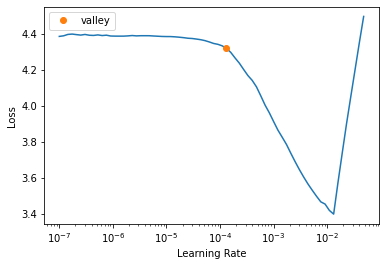

In [16]:
dls = dsets.dataloaders(bs=16, after_item=[albu_aug, ToTensor],
                        after_batch=[IntToFloatTensor(div_mask=255), 
                                     Normalize.from_stats(*imagenet_stats)])
img_size = [round(0.9*320) for _ in range(2)]

encoder = timm.create_model('efficientnet_b0', pretrained=True)

# Let's use self attentions and Mish activation function 
model = DynamicTimmUnet(encoder, 3, img_size, self_attention=True, act_cls=Mish)

# We'll also use ranger optimizer with is RAdam with Lookahead
learn = Learner(dls, model, metrics=metrics, loss_func=loss_func, splitter=dynamic_unet_splitter, opt_func=ranger).to_fp16()
learn.freeze()
learn.lr_find()

In [17]:
# Let's also use flat cosine annealing lr shceduler
lr = 1e-3
learn.fit_flat_cos(1, lr)

epoch,train_loss,valid_loss,dice_coeff_adj,hd_dist_adj,custom_metric_adj,time
0,0.991883,0.699887,0.562718,0.762979,0.682874,02:08


In [18]:
# Let's unfreeze the encoder layers and train with discriminative learning rates.
learn.unfreeze()
learn.fit_flat_cos(2, slice(lr/400, lr/4))

epoch,train_loss,valid_loss,dice_coeff_adj,hd_dist_adj,custom_metric_adj,time
0,0.805488,0.588406,0.645035,0.856163,0.771712,02:24
1,0.660503,0.477541,0.698127,0.851142,0.789936,02:23


# Inference

In [25]:
def create_df(df, fnames):
    df = df.copy()
    df = df.pivot(index='id', columns='class', values='segmentation').reset_index()
    
    df['partial_fname'] = df.id
    fname_df = pd.DataFrame({'partial_fname': [f'{fname.parts[-3]}_slice_{fname.parts[-1][6:10]}' for fname in fnames],
                             'fname': fnames})

    df = df.merge(fname_df, on='partial_fname').drop('partial_fname', axis=1)

    df['case_id'] = df.id.apply(lambda x: x.split('_')[0])
    df['day_num'] = df.id.apply(lambda x: x.split('_')[1])

    df['slice_w'] = df["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[1]))
    df['slice_h'] = df["fname"].apply(lambda x: int(str(x)[:-4].rsplit("_",4)[2]))
    
    channels = 3
    stride = 2
    for j, i in enumerate(range(-1*(channels-channels//2-1), channels//2+1)):
        method = 'ffill'
        if i <= 0: method = 'bfill'
        df[f'fname_{j:02}'] = df.groupby(['case_id', 'day_num'])['fname'].shift(stride*-i).fillna(method=method)

    df['fnames'] = df[[f'fname_{j:02d}' for j in range(channels)]].values.tolist()
    
    return df

def mask2rle(mask):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    mask = np.array(mask)
    pixels = mask.flatten()
    pad = np.array([0])
    pixels = np.concatenate([pad, pixels, pad])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]

    return " ".join(str(x) for x in runs)

def resize_img_to_org_size(img, org_size):
    shape0 = np.array(img.shape[:2])
    diff = org_size - shape0
    if np.any(diff < 0):
        img = pad_img_nc(img, (320, 384))
        resized = unpad_img_nc(img, org_size)
    else:
        resized = pad_img_nc(img, org_size)
    return resized

def get_rle_masks(preds, df):
    rle_masks = []
    for pred, width, height in zip(preds, df['slice_w'], df['slice_h']):
        upsized_mask = resize_img_to_org_size(pred, (height, width))
        for i in range(3):
            rle_mask = mask2rle(upsized_mask[:, :, i])
            rle_masks.append(rle_mask)
    return rle_masks

def unpad_img_nc(img, org_size):
    shape0 = np.array(org_size)
    resize = np.array(img.shape[:2])
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        
        if pady[0] != 0:
            img = img[pady[0]:-pady[1], :, :]
            
        if padx[0] != 0:
            img = img[:, padx[0]:-padx[1], :]
            
        img = img.reshape((*shape0, img.shape[-1]))
    return img

def pad_img_nc(img, up_size=None):
    if up_size is None:
        return img
    shape0 = np.array(img.shape[:2])
    resize = np.array(up_size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        padz = [0, 0]
        img = np.pad(img, [pady, padx, padz])
        img = img.reshape((*resize, img.shape[-1]))
    return img

def get_rle_masks(preds, df):
    rle_masks = []
    for pred, width, height in zip(preds, df['slice_w'], df['slice_h']):
        upsized_mask = resize_img_to_org_size(pred, (height, width))
        for i in range(3):
            rle_mask = mask2rle(upsized_mask[:, :, i])
            rle_masks.append(rle_mask)
    return rle_masks

In [22]:
data_path = 'dataset/'

train_path = Path(data_path+'train')
test_path = Path(data_path+'test')

train_fnames = get_image_files(train_path)
test_fnames = get_image_files(test_path)

sample_submission = pd.read_csv(data_path+'sample_submission.csv')

if sample_submission.shape[0] > 0: 
    test = sample_submission.copy()
else:
    test_fnames = train_fnames
    test_path = train_path
    train = pd.read_csv('dataset/train.csv', low_memory=False)
    test = train.copy()
    test = test.sample(frac=1.0, random_state=42)

test_df = create_df(test, test_fnames)


In [23]:
learn = load_learner('test_model.pkl')
# Sample the test set demonstartion purposes
test_df = test_df.sample(frac=0.1)
bs = learn.dls.bs
test_dl = learn.dls.test_dl(test_df, bs=bs, shuffle=False).to('cuda')

In [26]:
from tqdm import tqdm
import gc

learn.model = learn.model.cuda()
learn.model.eval()
masks = []

with torch.no_grad():
    for i, b in enumerate(tqdm(test_dl)):
        b.to('cuda')
        b_preds = (sigmoid(learn.model(b)) > 0.5).permute(0, 2, 3, 1).cpu().detach().numpy().astype(np.uint8)

        masks.extend(get_rle_masks(b_preds, test_df.iloc[i*bs:i*bs+bs]))

        # test_preds[i*bs:i*bs+bs] = b_preds
        del b_preds
        torch.cuda.empty_cache()
        gc.collect()

100%|██████████████████████████████████████████████████████████████████████████████████| 241/241 [00:50<00:00,  4.81it/s]


# Submission

In [27]:
def get_case_id(fname):
    return fname.parts[3] + '_' + fname.parts[5][:10]

In [28]:
from itertools import chain

submission = pd.DataFrame({
        'id': chain.from_iterable([[get_case_id(fname)]*3 for fname in test_df['fname']]),
        'class': chain.from_iterable([['large_bowel', 'small_bowel', 'stomach'] for _ in test_df['fname']]),
        'predicted': masks,
    })
    

# Merge with sample submission to preserve order to slices during scoring and avoid 0 scores
if sample_submission.shape[0] > 0:
    del sample_submission['segmentation']
    submission = sample_submission.merge(submission, on=['id', 'class'])

submission.to_csv('submission.csv', index=False)